# i. Application Understanding

* The Transecret is an online Bank App with an implemented system in detecting fraud in financial transactions made through mobile devices. Transcrete has a service called “Fraud Detection” with no guarantee of blocking fraudulent transactions.

* And the business model of Transcrete is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

## i.ii The Challenge

A production model in which your access will be done via API, that is, users will send their transactions via API so that your model classifies them as fraudulent or legitimate.

## Import Python packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
# import explainable_ai_sdk 
import explainable_ai_sdk as xai

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

2024-02-26 20:44:55.048501: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 20:44:55.101154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 20:44:55.101189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 20:44:55.102690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 20:44:55.111451: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 20:44:55.112687: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
#Step 1: Download the Kaggle dataset and read with Pandas
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
- [1 files][303.4 MiB/303.4 MiB]                                                
Operation completed over 1 objects/303.4 MiB.                                    


In [3]:
# read the dataset as a Pandas DataFrame and preview it
data = pd.read_csv('fraud_data_kaggle.csv')
data = data.drop(columns=['type'])
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


# Step 2: Accounting for imbalanced data
#### Here, we'll be using a technique called downsampling. 
### Downsampling means using only a small percentage of the majority class in training. 
### In this case, "non-fraud" is the majority class since it accounts for 99.9% of the data.

### To downsample our dataset, we'll take all ~8k of the fraudulent examples and a random sample of ~31k of the non-fraud cases. 
### This way the resulting dataset will have 25% fraud cases, compared to the .1% we had before.

In [4]:
# First, split the data into two DataFrames,
# one for fraud and one for non-fraud
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

# Then, take a random sample of the non-fraud cases.
#### We're using .005% since this will give us a 25/75 split of fraud / non-fraud transactions. 
#### With that, you can put the data back together and shuffle.
#### To simplify things we'll also remove a few columns that we won't be using for training:

In [5]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2880934,228,225995.98,187387.00,0.00,2089592.81,2315588.79,0.0
2485109,204,6758.80,25491.67,18732.88,0.00,0.00,0.0
3528108,259,21772.92,26341.00,4568.08,0.00,0.00,0.0
199110,13,582526.39,0.00,0.00,1110543.49,1693069.89,0.0
550022,21,93966.17,0.00,0.00,3581536.71,3675502.88,0.0


In [6]:
# Step 3: Split the data into train and test sets
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

## When training a model on numerical data, it's important to normalize the data, 
### especially if each column falls in a different range. 
### This can help prevent loss from exploding during training. 
### We can normalize our data with the following:

In [7]:
# Normalize the data
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set) # Only normalize on the train set
test_set = scaler.transform(test_set)

# clip() ensures all values fall within the range [-5,5]
# useful if any outliers remain after normalizing
train_set = np.clip(train_set, -5, 5)
test_set = np.clip(test_set, -5, 5)

## `Then, let's preview our normalized data:`

In [8]:

train_set

array([[ 0.74771568, -0.10558206, -0.24744663, -0.26469104,  0.51385876,
         0.48591169],
       [ 0.48352495, -0.33128635, -0.30457304, -0.25780596, -0.39568077,
        -0.43989138],
       [ 1.08896205, -0.31582934, -0.30427334, -0.26301209, -0.39568077,
        -0.43989138],
       ...,
       [-1.63000093, -0.2417149 ,  5.        ,  5.        , -0.32594475,
        -0.41332417],
       [ 0.50554084, -0.24271814, -0.31319682, -0.26469104, -0.39568077,
        -0.40279301],
       [-0.43013468, -0.28420772,  2.89581808,  3.09750739, -0.18409246,
        -0.26652501]])

# Step 2: Determine class weights

When downsampling the data, we still wanted to keep a subset of the non-fraudulent transactions so we didn't lose information on those transactions, which is why we didn't make the data perfectly balanced. Because the dataset is still imbalanced and we care most about correctly identifying fraudulent transactions, we want our model to give more weight to fraudulent examples in our dataset.

The Keras `class_weight` parameter lets us specify exactly how much weight we want to give examples from each class, based on how often they occur in the dataset:

In [9]:
weight_for_non_fraud = 1.0 / df['isFraud'].value_counts()[0]
weight_for_fraud = 1.0 / df['isFraud'].value_counts()[1]

class_weight = {0: weight_for_non_fraud, 1: weight_for_fraud}

##### We'll use this variable when we train our model in the next step.

# Step 3: Train and evaluate the model

We'll build our model using the Keras Sequential Model API, which lets us define our model as a stack of layers. There are a number of metrics we'll track as we're training, which will help us understand how our model is performing on each class in our dataset.

In [10]:


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_set.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

Then, we'll define a few global variables for use during training along with some early stopping parameters.

In [11]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Finally, we'll call the function we defined above to make our model:

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###### We can train our model with the `fit()` method, passing in parameters defined above:

In [13]:
results = model.fit(
    train_set,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(test_set, test_labels),
    class_weight=class_weight)

Epoch 1/100
38/38 [==============================] - 2s 15ms/step - loss: 6.5510e-05 - tp: 1875.0000 - fp: 12277.0000 - tn: 4154.0000 - fn: 834.0000 - accuracy: 0.3150 - precision: 0.1325 - recall: 0.6921 - auc: 0.4502 - val_loss: 0.8325 - val_tp: 498.0000 - val_fp: 2923.0000 - val_tn: 1161.0000 - val_fn: 204.0000 - val_accuracy: 0.3466 - val_precision: 0.1456 - val_recall: 0.7094 - val_auc: 0.4648
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 6.1529e-05 - tp: 1890.0000 - fp: 11452.0000 - tn: 4979.0000 - fn: 819.0000 - accuracy: 0.3589 - precision: 0.1417 - recall: 0.6977 - auc: 0.5003 - val_loss: 0.7574 - val_tp: 542.0000 - val_fp: 2825.0000 - val_tn: 1259.0000 - val_fn: 160.0000 - val_accuracy: 0.3763 - val_precision: 0.1610 - val_recall: 0.7721 - val_auc: 0.5484
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 5.8061e-05 - tp: 1893.0000 - fp: 10366.0000 - tn: 6065.0000 - fn: 816.0000 - accuracy: 0.4158 - precision: 0.1544 - recall: 

# Step 4: Visualize model metrics

Now that we have a trained model, let's see how our model performed by plotting various metrics throughout our training epochs:

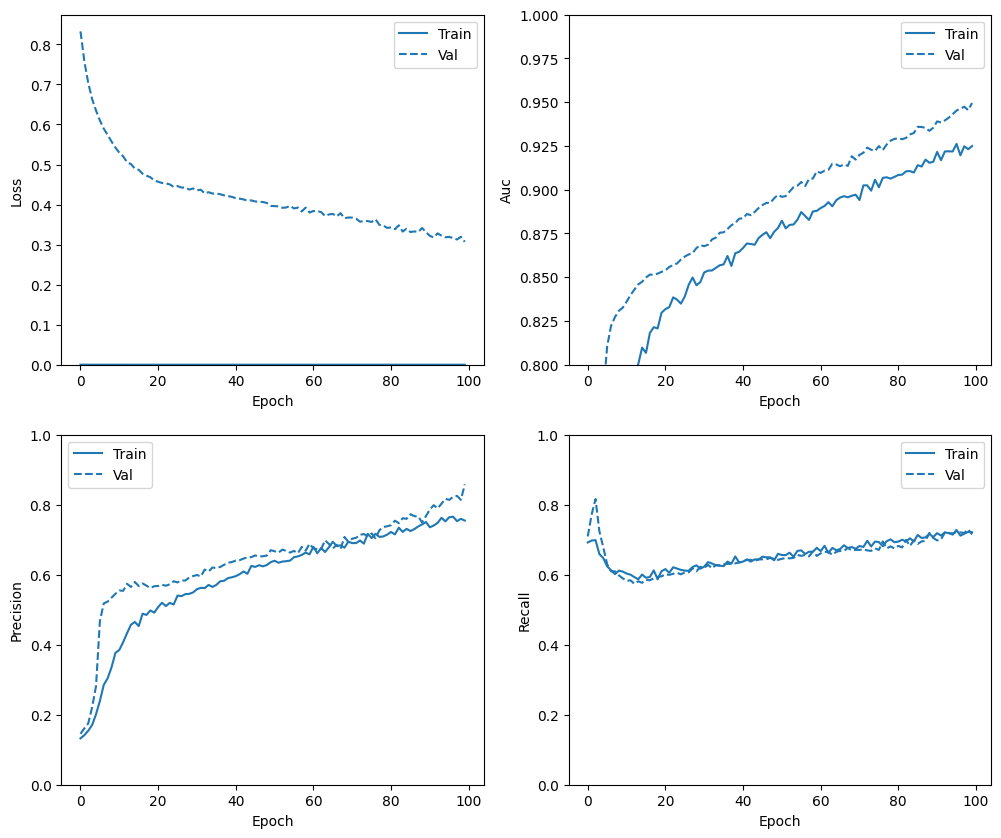

In [14]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(results)

# Step 5: Print a confusion matrix

A confusion matrix[https://en.wikipedia.org/wiki/Confusion_matrix] is a nice way to visualize how our model performed across the test dataset. For each class, it will show us the percentage of test examples that our model predicted correctly and incorrectly. Scikit Learn has some utilities for creating and plotting confusion matrices, which we'll use here.

At the beginning of our notebook we imported the `confusion_matrix` utility. To use it, we'll first create a list of our model's predictions. Here we'll round the values returned from our model so that this lists matches our list of ground truth labels:

In [15]:
predicted = model.predict(test_set)

y_pred = []

for i in predicted.tolist():
  y_pred.append(int(round(i[0])))

150/150 [==============================] - 0s 1ms/step


Now we're ready to feed this into the confusion_matrix method, along with our ground truth labels:

In [16]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[4001   83]
 [ 200  502]]


This shows us the absolute numbers of our model's correct and incorrect predictions on our test set. The number on the top left shows how many examples from our test set our model correctly predicted as non-fraudulent. The number on the bottom right shows how many it correctly predicted as fraudulent (we care most about this number). You can see that it predicted the majority of samples correctly for each class.

###### To make this easier to visualize, we've adapted the `plot_confusion_matrix` function from the Scikit Learn

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

And create the plot by passing it the data from our model. We're setting normalize to True here so that the confusion matrix displays the number of correct and incorrect predictions as percentages:

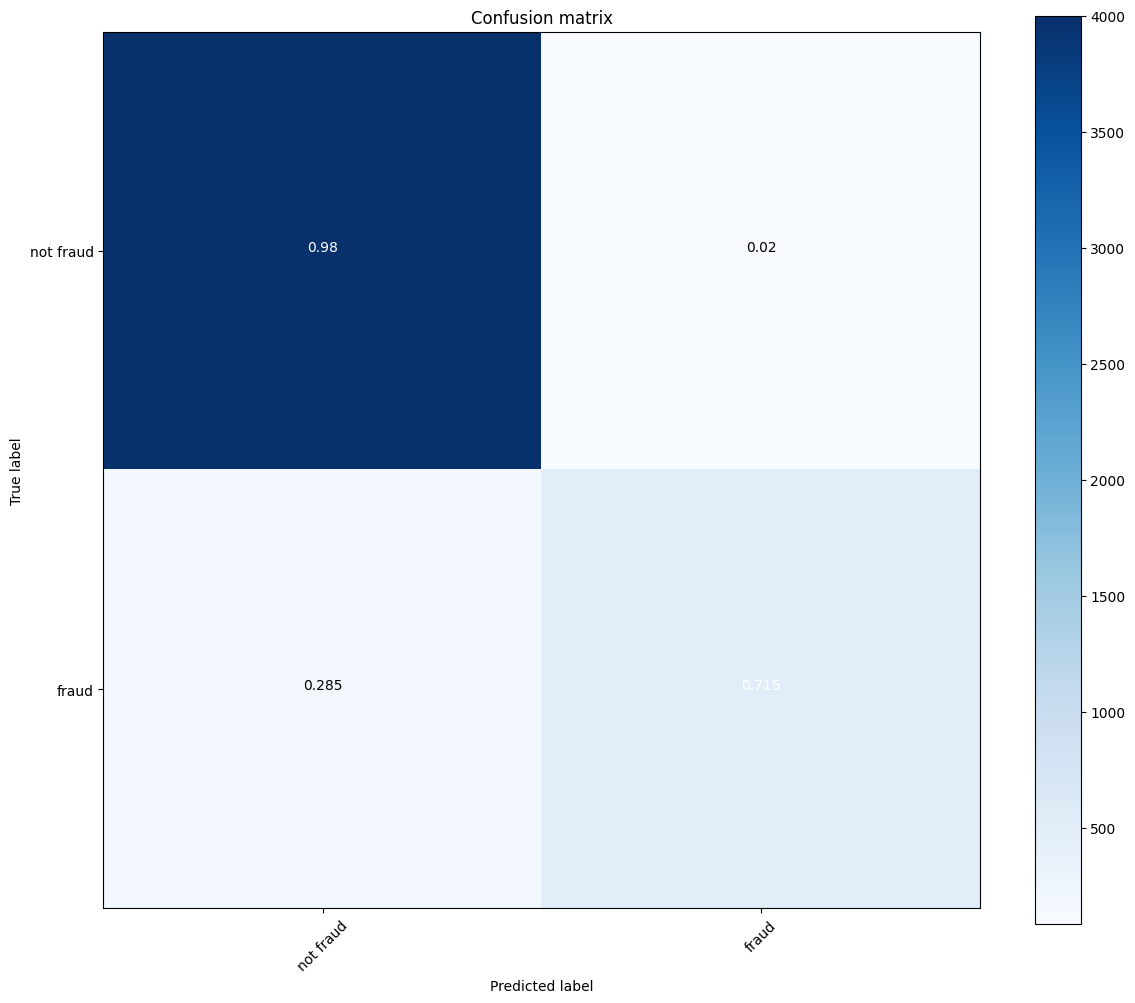

In [18]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

# 6. Using the Explainable AI SDK

## Step 1: Export trained model

#### we will save our model into a directory in our notebook instance:

In [19]:
model_dir = 'fraud_model'
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: fraud_model/assets


INFO:tensorflow:Assets written to: fraud_model/assets


##### a new directory called fraud_model/ created.

# Step 2: Get explanation metadata with the SDK

Next, we'll point the Explainable AI SDK at that directory. Doing this will generate metadata necessary for getting model explanations. The `get_metadata()` method shows metadata the SDK infers from your model, like input names:

In [20]:
model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

{'outputs': OrderedDict([('dense_1', {'output_tensor_name': 'dense_1'})]), 'inputs': OrderedDict([('dense_input', {'input_tensor_name': 'dense_input', 'encoding': 'identity', 'modality': 'numeric'})]), 'framework': 'tensorflow2', 'tags': ['explainable_ai_sdk']}


# Step 3: Specifying our model's baseline

###### For tabular data, the Explainable AI service works by returning attribution values for each feature. These values indicate how much a particular feature affected the prediction. Let's say the amount of a particular transaction caused our model to increase its predicted fraud probability by 0.2%. You might be thinking "0.2% relative to what??". That brings us to the concept of a baseline.

###### The baseline for our model is essentially what it's comparing against. We select the baseline value for each feature in our model, and the baseline prediction consequently becomes the value our model predicts when the features are set at the baseline.

###### Choosing a baseline depends on the prediction task you're solving. For numerical features, it's common to use the median value of each feature in your dataset as the baseline. In the case of fraud detection, however, this isn't exactly what we want. We care most about explaining the cases when our model labels a transaction as fraudulent. That means the baseline case we want to compare against is non-fraudulent transactions.

###### To account for this, we'll use the median values of the non-fraudulent transactions in our dataset as the baseline. We can get the median by using the `not_fraud_sample` DataFrame we extracted above, and scaling it to match our model's expected inputs:

In [21]:
not_fraud_sample = not_fraud_sample.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'])

baseline = scaler.transform(not_fraud_sample.values)
baseline = np.clip(baseline, -5, 5)
baseline_values = np.median(baseline, axis=0)

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


###### Note that we don't need to specify a baseline. If we don't, the SDK will use 0 as a baseline for each input value our model is expecting. In our fraud detection use case, it makes sense to specify a baseline, which we'll do below:

In [25]:
input_name = list(metadata['inputs'])[0]
model_builder.set_numeric_metadata(input_name, input_baselines=[baseline_values.tolist()], index_feature_mapping=df.columns.tolist()[:6])
model_builder.save_metadata(model_dir)
# Save your trained model
model.save('fraud_model/fraud_model.h5')

###### Running the `save_metadata()` method above created a file in our model's directory called `explanation_metadata.json`. In your notebook, navigate to the fraud_model/ directory to confirm that file was created. This contains metadata that the SDK will use to generate feature attributions.

# Step 4: Getting model explanations

###### We're now ready to get feature attributions on individual examples. To do that, we'll first create a local reference to our model using the SDK:

##### The first step is to export the model locally. We will use the AI Platform Explanability SDK method load_model_from_local_path(), with the parameters:

- `model_path`: The GCS location of the AI Platform model.
- `config`: The type of Exolainable AI explanations to instrument the local model f

In [ ]:
# local_model = xai.load_model_from_local_path(
#    model_path=model_dir,
#                                config=xai.model.configs.SampledShapleyConfig()

# )

# Next, let's get predictions and explanations on our model from an example transaction that should be classified as fraudulent:

In [ ]:
# fraud_example = [0.722,0.139,-0.114,-0.258,-0.271,-0.305]
# response = local_model.explain([{input_name: fraud_example}])
# response[0].visualize_attributions()

###### In this example, the account's initial balance before the transaction took place was the biggest indicator of fraud, pushing our model's prediction up from the baseline more than 0.5. The transaction's amount, resulting balance at the destination account, and step were the next biggest indicators. In the dataset, the "step" represents a unit of time (1 step is 1 hour). Attribution values can also be negative.

###### The `"approximation error"` that is printed above the visualizations lets you know how much you can trust the explanation. Generally, error over 5% means you may not be able to rely on the feature attributions. Remember that your explanations are only as good as the training data and model you used. Improving your training data, model, or trying a different model baseline can decrease the approximation error.

###### You may also be able to decrease this error by increasing the number of steps used in your explanation method. You can change this with the SDK by adding a `path_count` parameter to your explanation config (the default is 10 if you don't specify):

In [27]:
# local_model = xai.load_model_from_local_path(
#     model_dir, 
#     xai.SampledShapleyConfig(path_count=20)
# )
# model = tf.saved_model.load('fraud_model')
new_model = tf.keras.models.load_model('fraud_model/fraud_model.h5')
# Save the entire model as a `.keras` zip archive.
# model.save('fraud_model.keras')
# metadata = model_builder.load_metadata('fraud_model/explanation_metadata')  

###### There is lots more you can do with Explainable AI on this model. Some ideas include:

- Sending many examples to our model and averaging the attribution values to see if certain features are more important overall. We could use this to improve our model, and potentially remove features that aren't important
- Finding false positives that our model flags as fraud but are non-fraudulent transactions, and examining their attribution values
- Use a different baseline and see how this impacts the attribution values

# 7. Deploy the model to AI Platform Prediction

## Step 1: Copy your saved model directory to a Cloud Storage Bucket.

With the SDK steps we ran previously, you have everything you need to deploy your model to AI Platform. To prepare for deployment, you'll need to put your SavedModel assets and explanation metadata in a Cloud Storage Bucket that the Explainable AI service can read.

To do that, we'll define some environment variables. Fill in the values below with the name of your Google Cloud project and the name of the bucket you'd like to create (must be globally unique).

In [ ]:
# Update these to your own GCP project and model
GCP_PROJECT = 'graduation-project-1-414211'
MODEL_BUCKET = 'gs://fraud_detection_bucket'

Now we're ready to create a storage bucket to store our exported TensorFlow model assets. We'll point AI Platform at this bucket when we deploy the model.

##### Run this `gsutil` command from within your notebook to create a bucket:

In [ ]:
!gsutil mb -l 'us-central1' $MODEL_BUCKET

##### Then, copy your local model directory into that bucket:

In [ ]:
!gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/explanations

## Step 2: Deploy the model

Next, we'll define some variables we'll use in our deployment commands:

In [ ]:
MODEL = 'fraud_detection_Model'
VERSION = 'v1'
model_path = MODEL_BUCKET + '/explanations'

###### We can create the model with the following gcloud command:

In [ ]:
!gcloud ai-platform models create $MODEL --region=us-central1 
# !gcloud ai-platform models create $MODEL --region=us-west1

###### Now we're ready to deploy our first version of this model with gcloud. The version will take ~5-10 minutes to deploy:

In [ ]:
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $model_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-2 \
--explanation-method 'sampled-shapley' \
--num-paths 10 \
--region=us-central1 

In the `origin` flag, we pass in the Cloud Storage location of our saved model and metadata file. Explainable AI currently has two different explanation methods available for tabular models. Here we're using Sampled Shapley. The `num-paths` parameter indicates the number of paths sampled for each input feature. Generally, the more complex the model, the more approximation steps are needed to reach reasonable convergence.

#### To confirm your model deployed correctly, run the following gcloud command:

In [ ]:
!gcloud ai-platform versions describe $VERSION --model $MODEL --region=us-central1


##### The state should be READY.

## Step 3: Getting predictions and explanations on the deployed model

For the purposes of explainability, we care most about explaining the cases where our model predicts fraud. We'll send 5 test examples to our model that are all fraudulent transactions.

We'll use the Google Cloud CLI to get predictions. Run the following code to get the indices of all of the fraud examples from our test set:

In [ ]:
fraud_indices = []

for i,val in enumerate(test_labels):
    if val == 1:
        fraud_indices.append(i)

Next we'll save 5 examples in the format our model is expecting, and write them to a file:

In [ ]:
num_test_examples = 5

instances = []
for i in range(num_test_examples):
    ex = test_set[fraud_indices[i]]
    instances.append({input_name: ex.tolist()})

with open('prediction.json', 'a') as outputfile:
    json.dump({"instances": instances}, outputfile)

##### We can send these five examples to our model using gcloud:

In [ ]:
!gcloud beta ai-platform explain \
--model=$MODEL \
--version=$VERSION \
--region='us-central1' \
--json-request=prediction.json

In the response JSON, you'll see the attribution values for each feature across these examples. The `example_score` key for each example includes the model's prediction - in this case the percentage likelihood that a particular transaction is fraudulent.

## Finished 
### With Love By `Rogina Adnan`

In [ ]:
new_model = tf.saved_model.load('fraud_model')
# Prepare the input data


In [28]:
# Show the model architecture
# new_model.summary()
# print(new_model['Class'])
 # Make a prediction using the TensorFlow model
# predictions = model.predict(input_data)
# Load the SavedModel
# loaded_model = tf.saved_model.load(')

# Get the input and output tensors

input_data = np.array([[0.1, 0.2, 0.3, 0.4, 0.5]])
# Get the input and output tensors
signature_definition = new_model.signatures['serving_default']
input_tensor = signature_definition.inputs[0]

# Print the input tensor shape and data type
print(input_tensor.shape)
print(input_tensor.dtype)



AttributeError: 'Sequential' object has no attribute 'signatures'

In [ ]:
# Get the input and output tensors
# Prepare the input data
input_data = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]], dtype=np.float32)

In [32]:
dataset = tf.data.Dataset.from_tensor_slices(input_data)
# Batch the dataset to create a _BatchDataset
batch_dataset = dataset.batch(4)

# The resulting _BatchDataset has an element_spec of:
# TensorSpec(shape=(4, 4), dtype=tf.float32, name=None)
print(batch_dataset.element_spec)

TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)


In [ ]:
# Make predictions
print(dataset)
# for data in dataset:
    # predictions = model(data)
    # print(predictions)

In [60]:
# Assuming you have loaded your model (e.g., from a SavedModel)
m = tf.keras.models.load_model('fraud_model/fraud_model.h5')

# Sample transaction data (replace with your actual data)
new_transaction = {
    'amount': 1000,
    'step': 0
}

# Preprocess the data (example using scaling and one-hot encoding)
scaler = StandardScaler()
# onehot_encoder = tf.keras.utils.to_categorical(['New York'])  # Assuming categorical encoding
# Assuming you have assigned a unique label (e.g., 0) to "New York"
location_label = 0

# One-hot encode the label
onehot_encoder = tf.keras.utils.to_categorical([location_label])

preprocessed_data = scaler.fit_transform([
    [new_transaction['amount']]
])
preprocessed_data = np.concatenate([preprocessed_data, onehot_encoder], axis=1)

# Make the prediction
# Assuming you know the expected number of features (6)
num_missing_features = 6 - preprocessed_data.shape[1]
padding_array = np.zeros((preprocessed_data.shape[0], num_missing_features))
preprocessed_data = np.concatenate([preprocessed_data, padding_array], axis=1)
# Reshape as usual
preprocessed_data = preprocessed_data.reshape((1, 6))


# Make the prediction
prediction = new_model.predict(preprocessed_data)

# Interpret the prediction (example: assume model outputs probability)
if prediction[0][0] > 0.5:
    print(f"This transaction might be fraudulent. {prediction}")
else:
    print("This transaction seems likely to be legitimate.")

1/1 [==============================] - 0s 18ms/step
This transaction might be fraudulent. [[0.73639786]]
